In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt
from skimage import io, transform
import scipy.io as sio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import mywarper

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
parser = argparse.ArgumentParser(description='stat231_project1')
parser.add_argument('--epochs', type=int, default=300)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--num_worker', type=int, default=4)
parser.add_argument('--seed', type=int, default=12345)
parser.add_argument('--device', type=int, default=0)
parser.add_argument('--image_dir', type=str, default='./data/images/')
parser.add_argument('--landmark_dir', type=str, default='./data/landmarks/')
parser.add_argument('--path', type=str, default='./results/model/')
parser.add_argument('--log', type=str, default='./results/log/')
parser.add_argument('--appear_lr', type=float, default=1e-3)
parser.add_argument('--landmark_lr', type=float, default=1e-3)
parser.add_argument('--explore_latent_dim', type=float, default=4)

_StoreAction(option_strings=['--explore_latent_dim'], dest='explore_latent_dim', nargs=None, const=None, default=4, type=<class 'float'>, choices=None, help=None, metavar=None)

In [3]:
# Read Dataset
class data_reader(object):
    def __init__(self, root_dir, file_str_len, origin_name, file_format):
        self.root_dir = root_dir
        self.file_str_len = file_str_len
        self.origin_name = origin_name
        self.file_format = file_format

    def read(self, split, read_type):
        files_len = len([name for name in os.listdir(self.root_dir) 
                        if os.path.isfile(os.path.join(self.root_dir, name))])
        counter = 0
        idx = counter
        dataset = []
        train_dataset = []
        test_dataset = []
        while counter < files_len:
            name = self.origin_name + str(idx)
            if len(name) > self.file_str_len:
                name = name[len(name)-self.file_str_len:]
            try:
                if read_type == 'image':
                    data = io.imread(self.root_dir + name + self.file_format)
                elif read_type == 'landmark':
                    mat_data = sio.loadmat(self.root_dir + name + self.file_format)

                    data = mat_data['lms']
                dataset.append(data)
                counter = counter + 1
            except FileNotFoundError:
                pass
            idx = idx + 1
        n = len(dataset)
        train_dataset = np.array(dataset[:int((1-split)*n)])
        test_dataset = np.array(dataset[int((1-split)*n):])
        return train_dataset, test_dataset

In [4]:
# Construct Dataset
class ImgToTensor(object):
    def __call__(self, sample):
        if len(sample.shape) == 3:
            sample = sample.transpose((2, 0, 1))
        elif len(sample.shape) == 4:
            sample = sample.transpose((0, 3, 1, 2))
        else:
            print('ERROR!')
        return torch.tensor(sample, dtype=torch.float32)/255

class LandmarkToTensor(object):
    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float32)/128

class dataset_constructor(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample_data = self.dataset[idx]
        if self.transform:
            sample_data = self.transform(sample_data)
        return sample_data

In [5]:
args = parser.parse_args('')
args.cuda = torch.cuda.is_available()
#torch.cuda.set_device(args.device)

if not os.path.exists(args.path):
    os.makedirs(args.path)
if not os.path.exists(args.log):
    os.makedirs(args.log)

if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [6]:
SPLIT_RATIO = 0.2 #train-test split ratio

In [7]:
appearance_reader = data_reader(args.image_dir, 6, '000000', '.jpg')
appearance_train, appearance_test = appearance_reader.read(split=SPLIT_RATIO, \
                                                                read_type='image')
landmark_reader = data_reader(args.landmark_dir, 6, '000000', '.mat')
landmark_train, landmark_test = landmark_reader.read(split=SPLIT_RATIO, \
                                                                read_type='landmark')

n_train = len(appearance_train)
n_test = len(appearance_test)
n = n_train + n_test

#Align train faces and test faces to mean position
landmark_mean = np.mean(landmark_train, axis = 0)

warp_appearance_train = []
for i in range(n_train):
    warp_appearance_train.append(mywarper.warp(appearance_train[i,:,:], landmark_train[i,:,:], 
                                               landmark_mean))
warp_appearance_train = np.array(warp_appearance_train) #shape: n_train X 128 X 128 X 3

warp_appearance_test = []
for i in range(n_test):
    warp_appearance_test.append(mywarper.warp(appearance_test[i,:,:], landmark_test[i,:,:], 
                                               landmark_mean))
warp_appearance_test = np.array(warp_appearance_test) #shape: n_test X 128 X 128 X 3

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


class appearance_autoencoder(nn.Module):
    def __init__(self):
        super(appearance_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
        )

        self.fc1 = nn.Sequential(                    
            nn.Linear(128*8*8,50),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(50, 128, kernel_size=8, stride=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding = 1, output_padding = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding = 2, output_padding = 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        z = self.fc1(x.view(-1, 128*8*8))
        x_recon = self.decoder(z.reshape(-1, 50, 1, 1))
        return x_recon
    
    def encode(self, x):
        x = self.encoder(x)
        z = self.fc1(x.reshape(-1, 128*8*8))
        return z
        
    def decode(self, z):
        return self.decoder(z.reshape(-1, 50, 1, 1))
    
    def latent_stats(self, x):
        z = self.encode(x).cpu().detach().numpy()
        mean = np.mean(z, axis=0)
        std = np.std(z, axis=0)
        self.z_mean = mean
        self.z_std = std
        self.z_std_order = np.argsort(std)[::-1]
    
    def interpolation(self, dim_idx=0, n_sample=10):
        z_dim = self.z_std_order[dim_idx]
        z_std = self.z_std[z_dim]
        values = np.linspace(-2*z_std, 2*z_std, n_sample)
        z_sample = np.stack([self.z_mean]*n_sample, axis=0)
        z_sample[:, z_dim] += values
        
        return z_sample

    
class landmark_autoencoder(nn.Module):
    def __init__(self):
        super(landmark_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(68*2,100),
            nn.LeakyReLU(),
            nn.Linear(100,10),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10,100),
            nn.LeakyReLU(),
            nn.Linear(100, 68*2),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        z = self.encoder(x.view(-1, 68*2))
        x_recon = self.decoder(z)
        return x_recon.reshape(-1, 68, 2)
    
    def encode(self, x):
        return self.encoder(x.reshape(-1, 68*2))
    
    def decode(self, z):
        return self.decoder(z).reshape(-1, 68, 2)
    
    def latent_stats(self, x):
        z = self.encode(x).cpu().detach().numpy()
        mean = np.mean(z, axis=0)
        std = np.std(z, axis=0)
        self.z_mean = mean
        self.z_std = std
        self.z_std_order = np.argsort(std)[::-1]
    
    def interpolation(self, dim_idx=0, n_sample=10):
        z_dim = self.z_std_order[dim_idx]
        z_std = self.z_std[z_dim]
        values = np.linspace(-2*z_std, 2*z_std, n_sample)
        z_sample = np.stack([self.z_mean]*n_sample, axis=0)
        z_sample[:, z_dim] += values
        
        return z_sample

class autoencoder(object):
    def __init__(self, appear_lr, landmark_lr, use_cuda):
        self.appear_model = appearance_autoencoder()
        self.landmark_model = landmark_autoencoder()
        self.use_cuda = use_cuda
        if use_cuda:
            self.appear_model.cuda()
            self.landmark_model.cuda()
        self.criterion = nn.MSELoss()
        self.appear_optim = optim.Adam(self.appear_model.parameters(), lr=appear_lr)
        self.landmark_optim = optim.Adam(self.landmark_model.parameters(), lr=landmark_lr)

        # self.appear_lr_scheduler = optim.lr_scheduler.StepLR(self.appear_optim, step_size = 100, gamma=0.3, last_epoch=-1)
        # self.landmark_lr_scheduler = optim.lr_scheduler.StepLR(self.landmark_optim, step_size = 100, gamma=0.3, last_epoch=-1)

        
    def train_appear_model(self, epochs, trainloader):
        self.appear_model.train()
        epoch = 0
        train_losses = []
        for epoch in range(epochs):
            train_loss = 0
            #self.appear_lr_scheduler.step()
            for batch_idx, x in enumerate(trainloader):
                if self.use_cuda:
                    x = x.cuda()
                self.appear_optim.zero_grad() 
                output = self.appear_model(x)
                loss = self.criterion(output, x) 
                loss.backward()  
                self.appear_optim.step() 
                train_loss += loss.item()  
            train_losses.append(train_loss/len(trainloader))
            # print("Current learning rate is: {}".format(self.appear_lr_scheduler.get_lr()))
            print('Appearance training Epoch:{}, Training Loss:{:.6f}'.format(epoch, train_loss/len(trainloader)))
            

    def train_landmark_model(self, epochs, trainloader):
        self.landmark_model.train()
        epoch = 0
        train_losses = []
        for epoch in range(epochs):
            train_loss = 0
            # self.landmark_lr_scheduler.step()
            for batch_idx, x in enumerate(trainloader):  
                if self.use_cuda:
                    x = x.cuda()
                self.landmark_optim.zero_grad() 
                output = self.landmark_model(x)
                loss = self.criterion(output, x) 
                loss.backward()  
                self.landmark_optim.step() 
                train_loss += loss.item()  
            train_losses.append(train_loss/len(trainloader))
            # print("Current learning rate is: {}".format(self.landmark_lr_scheduler.get_lr()))
            print('Landmark training Epoch:{}, Training Loss:{:.6f}'.format(epoch, train_loss/len(trainloader)))


    def test_appear_model(self, testloader):
        self.appear_model.eval()
        test_losses = []
        test_loss = 0
        outputs = []
        for batch_idx, x in enumerate(testloader):
            if self.use_cuda:
                x = x.cuda()
            output = self.appear_model(x)
            outputs.append(output)
            loss = self.criterion(output, x)
            test_loss += loss.item()  
        test_losses.append(test_loss/len(testloader))
        print('Appearance testing Loss:{:.6f}.'.format(test_loss/len(testloader)))
        return test_losses


    def test_landmark_model(self, testloader):
        self.landmark_model.eval()
        test_losses = []
        test_loss = 0
        outputs = []
        for batch_idx, x in enumerate(testloader):
            if self.use_cuda:
                x = x.cuda()
            output = self.landmark_model(x)
            outputs.append(output)
            loss = self.criterion(output, x)
            test_loss += loss.item()
        
        test_losses.append(test_loss/len(testloader))
        print('Landmark testing Loss:{:.6f}.'.format(test_loss/len(testloader)))
        return test_losses
    
    def reconstruct(self, images, landmarks):
        self.appear_model.eval()
        self.landmark_model.eval()
        
        if self.use_cuda:
            landmarks = landmarks.cuda()
        
        # reconstruct landmarks
        landmark_recons = self.landmark_model(landmarks) * 128
        
        # warp images
        warp_images = []
        for i in range(images.shape[0]):
            image = images[i].transpose([1,2,0])
            landmark_recon = landmark_recons[i].cpu().detach().numpy()
            warp_image = mywarper.warp(image, landmark_recon, landmark_mean)
            warp_images.append(warp_image.transpose([2,0,1]))
        warp_images = np.array(warp_images)
        
        # reoncstruct appearances
        warp_images = torch.tensor(warp_images, dtype=torch.float32)
        if self.use_cuda:
            warp_images = warp_images.cuda()
        warp_image_recons = self.appear_model(warp_images)
        
        # warp back
        warp_image_recons = warp_image_recons.cpu().detach().numpy()
        image_recons = []
        for i in range(images.shape[0]):
            image = images[i].transpose([1,2,0])
            landmark = landmark_recons[i].cpu().detach().numpy()
            warp_image = mywarper.warp(warp_image_recons[i,:,:,:].transpose([1,2,0]), landmark_mean
                                       , landmark)
            image_recons.append(warp_image.transpose([2, 0, 1]))
        image_recons = np.array(image_recons)
        
        error = images - image_recons
        error = np.mean(error**2)
        
        return image_recons, error    
    
    def latent_stats(self, appearance_trainset, landmark_trainset):      
        self.appear_model.eval()
        self.landmark_model.eval()
        if self.use_cuda:
            appearance_trainset = appearance_trainset.cuda()
            landmark_trainset = landmark_trainset.cuda()
            
        self.appear_model.latent_stats(appearance_trainset)
        self.landmark_model.latent_stats(landmark_trainset)
        
    
    def interpolation(self, dim_idx=0, n_sample=10, type='landmark'):
        appearance_z_mean = self.appear_model.z_mean
        landmark_z_mean = self.landmark_model.z_mean
        if type == 'landmark':
            landmark_z = self.landmark_model.interpolation(dim_idx, n_sample)
            appearance_z = np.stack([appearance_z_mean]*n_sample, axis=0)
        elif type == 'appearance':
            landmark_z = np.stack([landmark_z_mean]*n_sample, axis=0)
            appearance_z = self.appear_model.interpolation(dim_idx, n_sample)
            
        img_recons = self.decode(torch.tensor(appearance_z), torch.tensor(landmark_z))
        return img_recons
    
    def decode(self, appear_latent, landmark_latent):
        self.appear_model.eval()
        self.landmark_model.eval()
        
        if self.use_cuda:
            landmark_latent = landmark_latent.cuda()
            appear_latent = appear_latent.cuda()
        
        landmark_recons = self.landmark_model.decode(landmark_latent) * 128
        appearance_recons = self.appear_model.decode(appear_latent)
        
        # warp back
        appearance_recons = appearance_recons.cpu().detach().numpy()
        image_recon = []
        for i in range(appearance_recons.shape[0]):
            image = appearance_recons[i].transpose([1,2,0])
            landmark = landmark_recons[i].cpu().detach().numpy()
            warp_image = mywarper.warp(image, landmark_mean, landmark)
            image_recon.append(warp_image.transpose([2, 0, 1]))
        image_recon = np.array(image_recon)
        
        return image_recon

In [9]:

#def main():
appearance_trainset = dataset_constructor(warp_appearance_train, transform=transforms.Compose([
                                                                    ImgToTensor()]))
appearance_testset = dataset_constructor(warp_appearance_test, transform=transforms.Compose([
                                                                    ImgToTensor()]))
appearance_trainloader = torch.utils.data.DataLoader(appearance_trainset, \
                                                    batch_size=args.batch_size, \
                                                    shuffle=True, \
                                                    num_workers=args.num_worker)
appearance_testloader = torch.utils.data.DataLoader(appearance_testset, \
                                                    batch_size=args.batch_size, \
                                                    shuffle=False, \
                                                    num_workers=args.num_worker)

landmark_trainset = dataset_constructor(landmark_train, transform=transforms.Compose([
                                                                    LandmarkToTensor()]))
landmark_testset = dataset_constructor(landmark_test, transform=transforms.Compose([
                                                                    LandmarkToTensor()]))
landmark_trainloader = torch.utils.data.DataLoader(landmark_trainset, \
                                                        batch_size=args.batch_size, \
                                                        shuffle=True, \
                                                        num_workers=args.num_worker)
landmark_testloader = torch.utils.data.DataLoader(landmark_testset, \
                                                        batch_size=args.batch_size, \
                                                        shuffle=False, \
                                                        num_workers=args.num_worker)

In [10]:
ae = autoencoder(args.appear_lr, args.landmark_lr, args.cuda)
ae.train_appear_model(args.epochs, appearance_trainloader)
appearance_test_loss = ae.test_appear_model(appearance_testloader)

ae.train_landmark_model(args.epochs, landmark_trainloader)
landmark_test_loss = ae.test_landmark_model(landmark_testloader)

Appearance training Epoch:0, Training Loss:0.143332
Appearance training Epoch:1, Training Loss:0.140120
Appearance training Epoch:2, Training Loss:0.091940
Appearance training Epoch:3, Training Loss:0.038513
Appearance training Epoch:4, Training Loss:0.023013
Appearance training Epoch:5, Training Loss:0.018776
Appearance training Epoch:6, Training Loss:0.016987
Appearance training Epoch:7, Training Loss:0.016051
Appearance training Epoch:8, Training Loss:0.015524
Appearance training Epoch:9, Training Loss:0.015155
Appearance training Epoch:10, Training Loss:0.014946
Appearance training Epoch:11, Training Loss:0.014795
Appearance training Epoch:12, Training Loss:0.014591
Appearance training Epoch:13, Training Loss:0.014348
Appearance training Epoch:14, Training Loss:0.014216
Appearance training Epoch:15, Training Loss:0.013993
Appearance training Epoch:16, Training Loss:0.013768
Appearance training Epoch:17, Training Loss:0.013635
Appearance training Epoch:18, Training Loss:0.013223
App

Appearance training Epoch:154, Training Loss:0.003023
Appearance training Epoch:155, Training Loss:0.002986
Appearance training Epoch:156, Training Loss:0.002972
Appearance training Epoch:157, Training Loss:0.002962
Appearance training Epoch:158, Training Loss:0.002951
Appearance training Epoch:159, Training Loss:0.003096
Appearance training Epoch:160, Training Loss:0.003281
Appearance training Epoch:161, Training Loss:0.002994
Appearance training Epoch:162, Training Loss:0.002942
Appearance training Epoch:163, Training Loss:0.002916
Appearance training Epoch:164, Training Loss:0.002908
Appearance training Epoch:165, Training Loss:0.002965
Appearance training Epoch:166, Training Loss:0.002929
Appearance training Epoch:167, Training Loss:0.002876
Appearance training Epoch:168, Training Loss:0.002857
Appearance training Epoch:169, Training Loss:0.003055
Appearance training Epoch:170, Training Loss:0.003020
Appearance training Epoch:171, Training Loss:0.002913
Appearance training Epoch:17

Landmark training Epoch:6, Training Loss:0.002952
Landmark training Epoch:7, Training Loss:0.002746
Landmark training Epoch:8, Training Loss:0.002677
Landmark training Epoch:9, Training Loss:0.002631
Landmark training Epoch:10, Training Loss:0.002597
Landmark training Epoch:11, Training Loss:0.002574
Landmark training Epoch:12, Training Loss:0.002542
Landmark training Epoch:13, Training Loss:0.002499
Landmark training Epoch:14, Training Loss:0.002441
Landmark training Epoch:15, Training Loss:0.002355
Landmark training Epoch:16, Training Loss:0.002238
Landmark training Epoch:17, Training Loss:0.002065
Landmark training Epoch:18, Training Loss:0.001832
Landmark training Epoch:19, Training Loss:0.001562
Landmark training Epoch:20, Training Loss:0.001258
Landmark training Epoch:21, Training Loss:0.000955
Landmark training Epoch:22, Training Loss:0.000747
Landmark training Epoch:23, Training Loss:0.000623
Landmark training Epoch:24, Training Loss:0.000547
Landmark training Epoch:25, Trainin

Landmark training Epoch:166, Training Loss:0.000221
Landmark training Epoch:167, Training Loss:0.000216
Landmark training Epoch:168, Training Loss:0.000214
Landmark training Epoch:169, Training Loss:0.000213
Landmark training Epoch:170, Training Loss:0.000207
Landmark training Epoch:171, Training Loss:0.000207
Landmark training Epoch:172, Training Loss:0.000202
Landmark training Epoch:173, Training Loss:0.000200
Landmark training Epoch:174, Training Loss:0.000205
Landmark training Epoch:175, Training Loss:0.000202
Landmark training Epoch:176, Training Loss:0.000195
Landmark training Epoch:177, Training Loss:0.000197
Landmark training Epoch:178, Training Loss:0.000192
Landmark training Epoch:179, Training Loss:0.000189
Landmark training Epoch:180, Training Loss:0.000185
Landmark training Epoch:181, Training Loss:0.000183
Landmark training Epoch:182, Training Loss:0.000180
Landmark training Epoch:183, Training Loss:0.000181
Landmark training Epoch:184, Training Loss:0.000172
Landmark tra

In [11]:
model_state = {"appear_state_dict": ae.appear_model.state_dict(), "landmark_state_dict": ae.landmark_model.state_dict()}
torch.save(model_state, args.log+'model.pth')

## Reconstruction

In [12]:
ae = autoencoder(args.appear_lr, args.landmark_lr, args.cuda)
state = torch.load(args.log+'model.pth')
ae.appear_model.load_state_dict(state['appear_state_dict'])
ae.landmark_model.load_state_dict(state['landmark_state_dict'])

<All keys matched successfully>

In [13]:
n_sample = len(appearance_testset)

appearances = np.array([appearance_testset[i].numpy() for i in range(n_sample)])
landmarks = landmark_testset[:n_sample]
appearance_recons, error = ae.reconstruct(appearances, landmarks)
print("Recon error: %.5f"%error)

appearance_recons = appearance_recons.transpose([0, 2, 3, 1])

Recon error: 0.00983


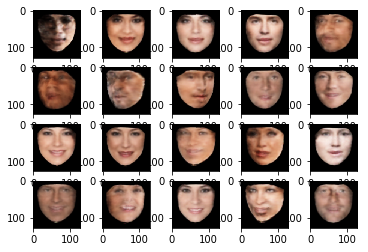

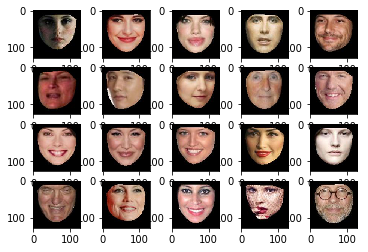

In [14]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(appearance_recons[i,:,:,:])
plt.figure()
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(appearance_test[i,:,:,:])

## Interpolation

In [15]:
ae = autoencoder(args.appear_lr, args.landmark_lr, args.cuda)
state = torch.load(args.log+'model.pth')
ae.appear_model.load_state_dict(state['appear_state_dict'])
ae.landmark_model.load_state_dict(state['landmark_state_dict'])

<All keys matched successfully>

In [16]:
ae.latent_stats(appearance_trainset[:], landmark_trainset[:])

Exploring landmark
Axis: 0


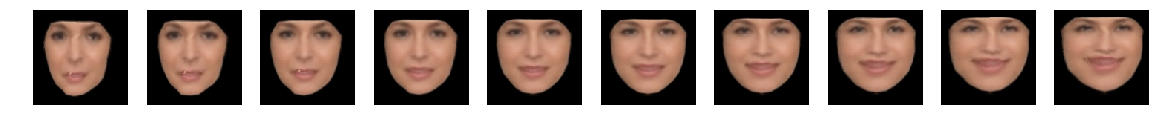

Axis: 1


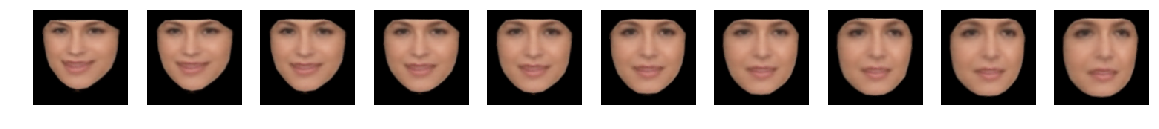

Axis: 2


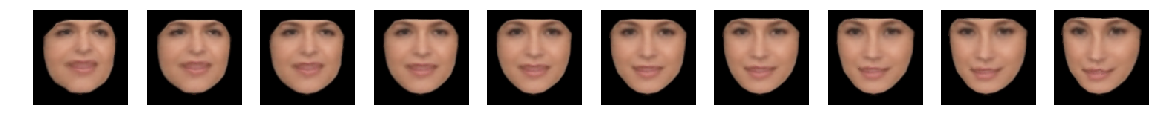

Axis: 3


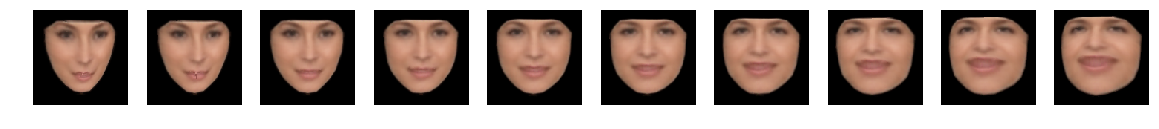

Exploring appearance
Axis: 0


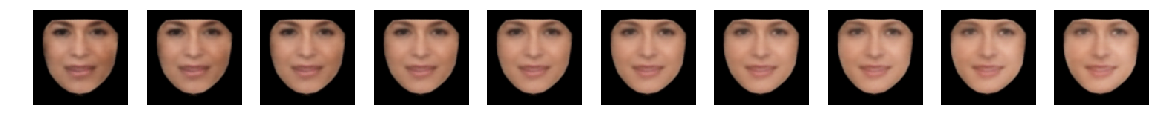

Axis: 1


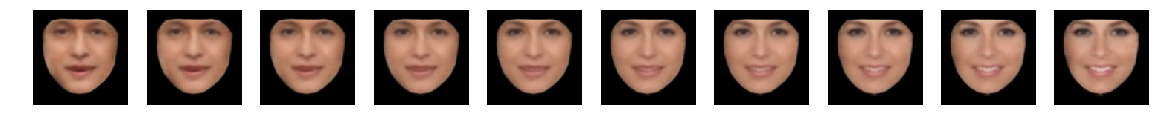

Axis: 2


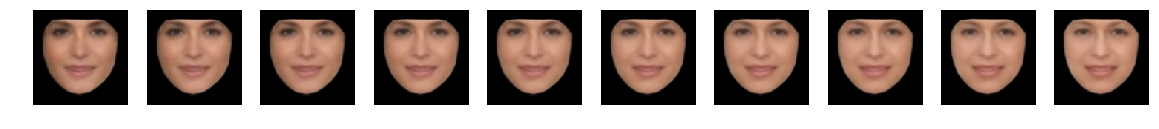

Axis: 3


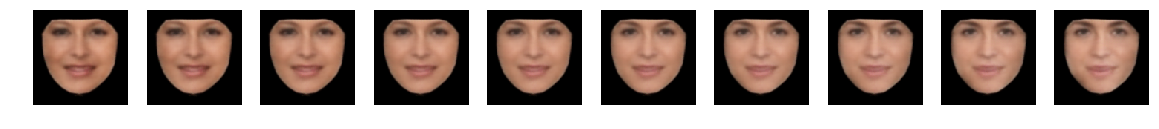

In [17]:
for type in ['landmark', 'appearance']:
    print("Exploring " + type)
    for dim_idx in range(args.explore_latent_dim):
        print("Axis: "+str(dim_idx))
        image_recons = ae.interpolation(dim_idx=dim_idx, n_sample=10, type=type)
        image_recons = image_recons.transpose([0, 2, 3, 1])
        fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20,4))
        idx = 0
        for row in ax:
            col = row
            col.axis('off')
            col.imshow(image_recons[idx])
            idx += 1
        plt.savefig(args.log + 'interpolation_%s_%d.png'%(type, dim_idx), bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()